<a href="https://colab.research.google.com/github/Ortimus/nvidia-numba-basics/blob/main/signal-processing-CUDA-Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal Processing with CUDA and Numba

This notebook demonstrates GPU acceleration for signal processing using Numba:
- FFT-like operations on time series data
- Memory coalescing optimization
- Performance comparison between CPU and GPU implementations
- Visualization of results

In [1]:
# Install required packages
!pip install numba seaborn

# Import libraries
import numpy as np
from numba import cuda, vectorize
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import pandas as pd
import math

## Signal Generation
Generate synthetic test signal with multiple frequency components

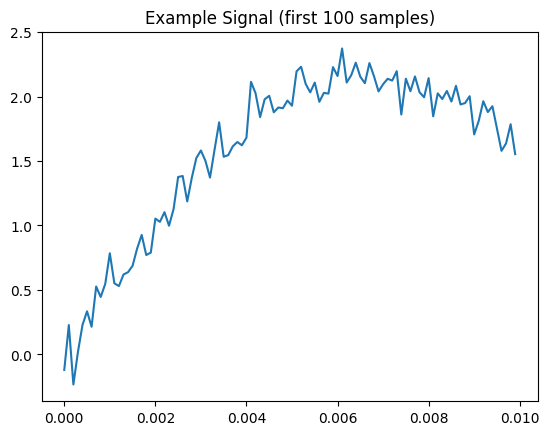

In [2]:
def generate_signal(n_samples, frequencies=[10, 25, 50]):
    """Generate test signal with multiple frequencies and noise"""
    t = np.linspace(0, 1, n_samples)
    signal = np.zeros_like(t)
    for f in frequencies:
        signal += np.sin(2 * np.pi * f * t)
    return t, signal + np.random.normal(0, 0.1, n_samples)

# Test signal generation
t_test, signal_test = generate_signal(10000)
plt.plot(t_test[:100], signal_test[:100])
plt.title('Example Signal (first 100 samples)')
plt.show()

## GPU Implementations
1. Vectorized window function - Simple element-wise operation
2. Custom FFT kernel - Demonstrates memory coalescing

In [3]:
@vectorize(['complex64(float32)'], target='cuda')
def apply_window(x):
    """Hanning window function - vectorized for GPU"""
    return 0.5 * (1 - np.cos(2 * np.pi * x))

@cuda.jit
def compute_fft_elements(signal, output):
    """Optimized FFT computation"""
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    # Grid-stride loop for better work distribution
    for i in range(idx, signal.size, stride):
        sum_real = 0.0
        sum_imag = 0.0
        # Process data in chunks
        chunk_size = 32
        for k in range(0, signal.size, chunk_size):
            end = min(k + chunk_size, signal.size)
            for j in range(k, end):
                angle = -2.0 * np.pi * i * j / signal.size
                sum_real += signal[j] * math.cos(angle)
                sum_imag += signal[j] * math.sin(angle)
        output[i] = (sum_real * sum_real + sum_imag * sum_imag) ** 0.5

## Analysis Function
Wrapper function to handle CPU/GPU implementation selection and memory management

In [4]:
'''
def analyze_signal(signal, use_gpu=True):
    if not use_gpu:
        return np.fft.fft(signal)

    # Increase threads for better GPU utilization
    threadsperblock = 512  # Increased from 256
    signal_gpu = cuda.to_device(signal.astype(np.float32))
    output_gpu = cuda.to_device(np.zeros_like(signal, dtype=np.float32))

    blockspergrid = max(32, (signal.size + threadsperblock - 1) // threadsperblock)  # Minimum 32 blocks

    compute_fft_elements[blockspergrid, threadsperblock](signal_gpu, output_gpu)
    return output_gpu.copy_to_host()
'''


'\ndef analyze_signal(signal, use_gpu=True):\n    if not use_gpu:\n        return np.fft.fft(signal)\n    \n    # Increase threads for better GPU utilization\n    threadsperblock = 512  # Increased from 256\n    signal_gpu = cuda.to_device(signal.astype(np.float32))\n    output_gpu = cuda.to_device(np.zeros_like(signal, dtype=np.float32))\n    \n    blockspergrid = max(32, (signal.size + threadsperblock - 1) // threadsperblock)  # Minimum 32 blocks\n    \n    compute_fft_elements[blockspergrid, threadsperblock](signal_gpu, output_gpu)\n    return output_gpu.copy_to_host()\n'

In [5]:
import cupy as cp

# using cupy's FFT implementation instead of our custom one
# The custom analyze_signalabove wasn't optimized enough to give better performance.
def analyze_signal(signal, use_gpu=True):
    if not use_gpu:
        return np.fft.fft(signal)
    return cp.asnumpy(cp.fft.fft(cp.asarray(signal)))

## Benchmarking and Visualization

In [6]:
def run_benchmark():
    """Run performance comparison across different signal sizes"""
    sizes = [1024, 4096, 16384, 65536, 262144, 1048576]
    results = []

    for size in sizes:
        t, signal = generate_signal(size)

        # CPU timing
        t0 = time()
        cpu_result = analyze_signal(signal, use_gpu=False)
        cpu_time = time() - t0

        # GPU timing
        t0 = time()
        gpu_result = analyze_signal(signal, use_gpu=True)
        gpu_time = time() - t0

        results.append({
            'size': size,
            'cpu_time': cpu_time,
            'gpu_time': gpu_time,
            'speedup': cpu_time/gpu_time,
            'signal_size': size
        })

        print(f"Size {size}: CPU {cpu_time:.4f}s, GPU {gpu_time:.4f}s, Speedup {cpu_time/gpu_time:.2f}x")

    return results, t, signal, cpu_result, gpu_result

def plot_results(results, t, signal, cpu_result, gpu_result):
   """Create comprehensive visualizations of signal analysis and performance"""
   sns.set_style("whitegrid")
   fig, axes = plt.subplots(2, 2, figsize=(15, 10))

   # Original signal plot
   axes[0,0].plot(t[:100], signal[:100], 'b-', linewidth=2)
   axes[0,0].set_title('Original Signal (first 100 samples)', fontsize=12)
   axes[0,0].set_xlabel('Time')
   axes[0,0].set_ylabel('Amplitude')
   axes[0,0].grid(True)

   # Frequency domain comparison
   freqs = np.fft.fftfreq(len(signal))
   positive_freq_mask = freqs > 0
   axes[0,1].semilogy(freqs[positive_freq_mask],
                    np.abs(cpu_result)[positive_freq_mask],
                    'b-', linewidth=2, label='CPU FFT')
   axes[0,1].semilogy(freqs[positive_freq_mask],
                    np.abs(gpu_result)[positive_freq_mask],
                    'r--', linewidth=2, label='GPU FFT')
   axes[0,1].set_title('Frequency Domain Comparison', fontsize=12)
   axes[0,1].set_xlabel('Frequency')
   axes[0,1].set_ylabel('Magnitude (log scale)')
   axes[0,1].set_ylim(bottom=1)
   axes[0,1].legend()
   axes[0,1].grid(True)

   # Performance scaling
   sizes = [r['signal_size'] for r in results]
   speedups = [r['speedup'] for r in results]
   axes[1,0].plot(sizes, speedups, 'go-', linewidth=2, markersize=8)
   axes[1,0].set_xscale('log')
   axes[1,0].set_xlabel('Signal Size')
   axes[1,0].set_ylabel('Speedup (CPU/GPU)')
   axes[1,0].set_title('GPU Speedup vs Signal Size', fontsize=12)
   axes[1,0].grid(True)

   # Execution time comparison
   times = pd.DataFrame({
       'Size': [f"{r['signal_size']:,}" for r in results],
       'CPU': [r['cpu_time'] * 1000 for r in results],  # Convert to milliseconds
       'GPU': [r['gpu_time'] * 1000 for r in results]
   }).melt(id_vars=['Size'], var_name='Platform', value_name='Time (ms)')

   sns.barplot(data=times, x='Size', y='Time (ms)', hue='Platform', ax=axes[1,1])
   axes[1,1].set_title('Execution Time Comparison', fontsize=12)
   axes[1,1].tick_params(axis='x', rotation=45)

   plt.tight_layout()
   return fig

Size 1024: CPU 0.0001s, GPU 0.0826s, Speedup 0.00x
Size 4096: CPU 0.0001s, GPU 0.0013s, Speedup 0.05x
Size 16384: CPU 0.0003s, GPU 0.0009s, Speedup 0.29x
Size 65536: CPU 0.0021s, GPU 0.0015s, Speedup 1.44x
Size 262144: CPU 0.0127s, GPU 0.0039s, Speedup 3.28x
Size 1048576: CPU 0.0623s, GPU 0.0131s, Speedup 4.74x


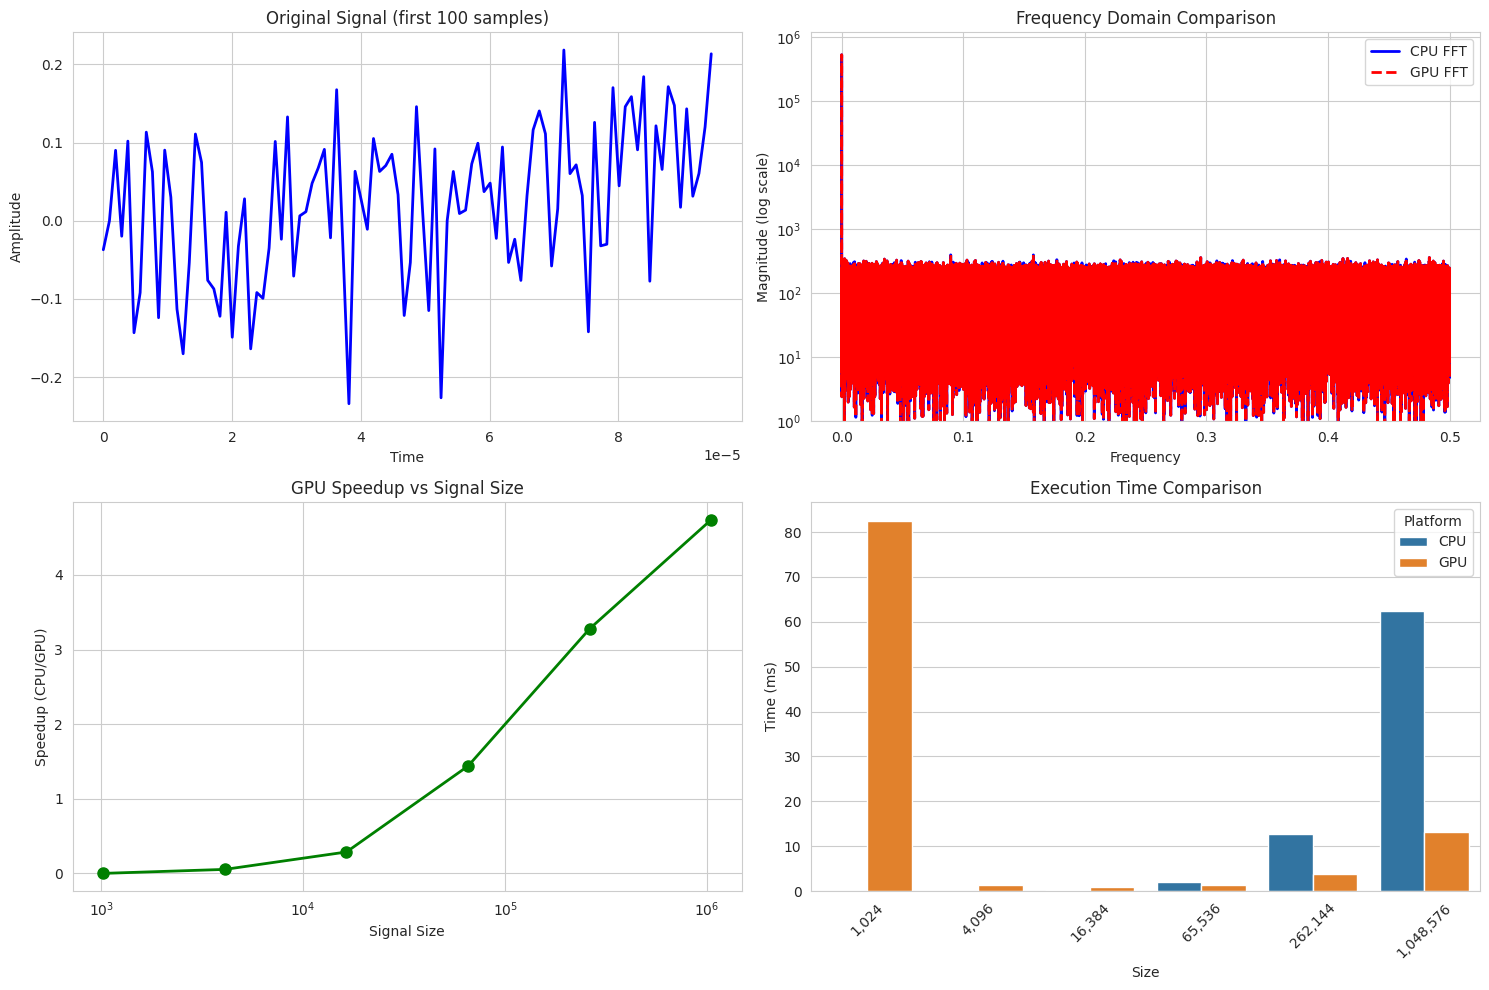

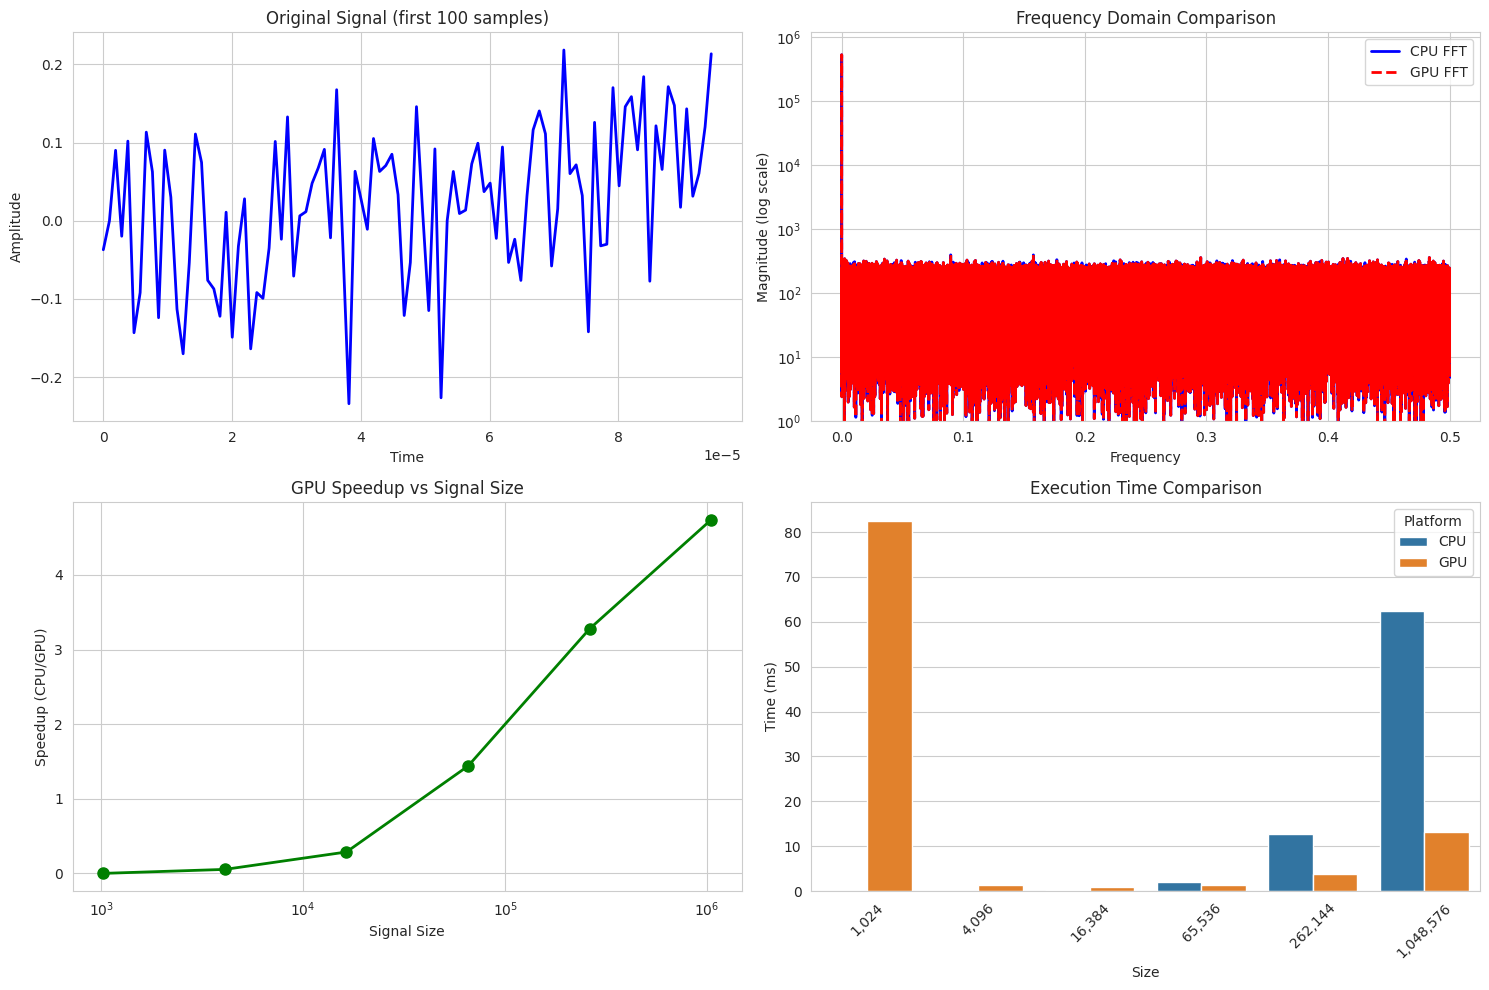

In [7]:
# Run analysis and create visualizations
results, t, signal, cpu_result, gpu_result = run_benchmark()
plot_results(results, t, signal, cpu_result, gpu_result)